# Herramientas para el MoDem LoRa

En las siguientes celdas se procederá con las herramientas de verificación y rendimiento, perfectas para determinar cualitativa y cuantitativamente nuestra implementación

## Herramienta Auxiliar: Generador de AWGN para señales complejas

Para poder generar AWGN y que dependa de un SNR parametrizado, podemos aprovecharnos de que para la fórmula:

$SNR = \frac{P_S}{P_N}$

Ya conoceríamos el valor del $SNR$ por lo que deberíamos calcular:

$P_N = \frac{P_S}{SNR}$

Esto nos permite conocer la potencia del ruido, que no es más que la varianza que tendrá la función de distribución normal asociada al mismo.

Por lo tanto, una vez conocida la varianza y sabiendo que la media siempre será el valor de la muestra, se puede computar el ruido para toda la señal:

$r(t)= w(t) + \sim N(0,\sigma)$

In [32]:
import numpy as np
def signal_power(signal):
    # Calculate the signal power
    P = np.mean(np.abs(signal)**2)
    return P

def generate_awgn(SNR, w):
    # Check if SNR is given in dB, DB, or db and convert if necessary
    if isinstance(SNR, str) and SNR.lower().endswith('db'):
        SNR_linear = 10 ** (float(SNR[:-2]) / 10)
    elif isinstance(SNR, int) or isinstance(SNR, float):
        SNR_linear = float(SNR)
    else:
        raise ValueError("SNR must be a number or a string ending with 'dB'.")
    
    if SNR_linear <= 0:
        raise ValueError("SNR must be a positive value.")
    signal_len = len(w)

    # Determine the noise power (variance)
    variance = signal_power(w) / SNR_linear
    # Generate noise
    noise = noise = np.sqrt(variance / 2) * (np.random.randn(signal_len) + 1j * np.random.randn(signal_len))
    
    # Add noise to the signal
    noisy_signal = w + noise
    
    return noisy_signal, noise, variance

## Herramienta Auxiliar: Generador del Codebook completo

In [33]:
from lora_modem import LoraModulator, SimpleLoraMoDem
def generate_all_symbols(sf, spc=1, bw=125e3, modulator= "complete"):
    """Genera todos los posibles símbolos LoRa mediante un modulador configurado (para un spreading factor, bandwidth y samples per chip especifico) en una señal, con cada símbolo concatenado de manera ascendente."""
    symbol_signals = []

    if modulator == "simple":
        mod = SimpleLoraMoDem(sf, bw, spc)
        for i in range(2**sf):
            symbol_signals.append(mod.modulate_symbols([i]))

    elif modulator == "complete":
        mod = LoraModulator(sf, bw, spc)
        for i in range(2**sf):
            symbol_signals.append(mod.modulate_symbols([i])[2])

    else:
        raise ValueError("Modulator must be 'simple' (SimpleLoraMoDem) or 'complete' (LoraModulator).")
    
    return symbol_signals

def generate_all_framed_symbols(sf, spc=1, bw=125e3, preamble_number = 8):
    """Genera todos los posibles símbolos LoRa con su trama correspondiente, mediante un modulador configurado (para un spreading factor, bandwidth y samples per chip especifico) en una señal, con cada símbolo concatenado de manera ascendente."""
    symbol_signals = []

    mod = LoraModulator(sf, bw, spc)
    for i in range(2**sf):
        symbol_signals.append(mod.modulate_explicit_package(preamble_number, [i])[2])
    
    return symbol_signals

## Comprobación del funcionamiento del MoDem: **Una Mirada Cualitativa**

Para poder comprobar que la implementación en código funciona correctamente (sin entrar específicamente en el rendimiento), a continuación se desarrolla una función que consistirá en:
- Generar todos los símbolos posibles para varias configuraciones con Spreading Factor ($2^{SF}$ símbolos), muestras por chip y ancho de banda dados.
- Demodularlos sin ruido añadido
- Comparar de que para cada símbolo modulado, se lo pueda demodular correctamente al símbolo original

Además, se graficará uno de los resultados para poder visualizar mejor los resultados de la prueba.

In [34]:
from lora_modem import LoraModulator, LoraDemodulator
import numpy as np
import matplotlib.pyplot as plt

def test_all_symbols(spreading_factor, bandwidth, samples_per_chip, plot=True):
    modulator = LoraModulator(spreading_factor, bandwidth, samples_per_chip)
    demodulator = LoraDemodulator(spreading_factor, bandwidth, samples_per_chip)
    symbols_to_send= [i for i in range(2**spreading_factor)]
    signal = modulator.modulate_symbols(symbols_to_send)[2]
    received_symbols = demodulator.demodulate_symbols(signal)

    if plot:
        if symbols_to_send == received_symbols:
            config = f"spc={samples_per_chip}, sf={spreading_factor}, bw={bandwidth/1000}kHz"
            plt.title(f'Demodulation successful for {config}: every symbol was correctly demodulated')
        else:
            plt.title('Error in demodulation')

        plt.plot(symbols_to_send,'o', label='Sent symbols', markersize=8, color = 'black')
        plt.plot(received_symbols, '*', label='Received symbols', markersize=6, color = 'white', markeredgecolor='orange')
        plt.legend()
    
    else:
        if symbols_to_send != received_symbols:
            print(f'Error in demodulation: {symbols_to_send} != {received_symbols}')
        else:
            config = f"spc={samples_per_chip}, sf={spreading_factor}, bw={bandwidth/1000}kHz"
            print(f'Demodulation successful for {config}: every symbol was correctly demodulated')
    return symbols_to_send, received_symbols

# print('Test 1 (Plotted): Testing if all symbols are correctly demodulated when spc=1, spreading factor=7, bandwidth=125kHz')
# plt.figure(figsize=(15, 8))
# sent_symbols, received_symbols = test_all_symbols(7, 125e3, 1, plot=True)
# plt.grid()
# plt.show()

# print('Test 2: Testing if all symbols are correctly demodulated when spc=[2, 4,8, 10], spreading factor=7, bandwidth=125kHz')
# for spc in [2, 4, 8, 10]:
#     test_all_symbols(8, 125e3, spc, plot=False)

# print('Test 3: Testing if all symbols are correctly demodulated when spc=1, spreading factor=[7, 8, 9, 10, 11, 12], bandwidth=125kHz')
# for sf in [7, 8, 9, 10, 11, 12]:
#     test_all_symbols(sf, 125e3, 1, plot=False)

# print('Test 4: Testing if all symbols are correctly demodulated when spc=1, spreading factor=7, bandwidth=[125e3, 250e3, 500e3]')
# for bw in [125e3, 250e3, 500e3]:
#     test_all_symbols(7, bw, 1, plot=False)

## Comprobación del Funcionamiento del MoDem: **Una Mirada Cuantitativa**

Para llevar a cabo una implementación correcta, siempre es necesario recurrir a herramientas capaces de diferenciar una técnica robusta de una propensa a errores.
En este caso, la robustez de LoRa radica más en cuestiones de rendimiento frente al ruido y no tanto, por ejemplo, en la capacidad de transferecnias de datos.

Por lo tanto, se llevarán a cabo 2 métricas, donde cada una tendrá 2 variantes:

- SNR (dB) x BER (bit error rate)
  1. Cuando la señal de entrada se somete a AWGN
  2. Cuando la señal de entrada se somete a AWGN + canal multipath selectivo en frecuencia con respuesta al impulso $h(t)=\sqrt{0.8}\delta (nT) + \sqrt(0.2) \delta (nT-T)$
- SNR (dB) x SER (symbol error rate)
  1. Cuando la señal de entrada se somete a AWGN
  2. Cuando la señal de entrada se somete a AWGN + canal multipath selectivo en frecuencia con respuesta al impulso $h(t)=\sqrt{0.8}\delta (nT) + \sqrt(0.2) \delta (nT-T)$
   
Nota: Debido a la carga computacional que supone evaluar el rendimiento para estas técnicas, las funciones generadoras de telemetría se preprocesarán y se almacenarán para su posterior visualización en la carpeta de mediciones (Measures)

### Métrica de Rendimiento cuantitativa **SNRxBER**, Solo AWGN

In [35]:
def generate_BER_SNR_ratio_binary(sf, bw=125e3, spc=1, simulations_number=1000000, snr_range=None, modulator = "complete"):
    """Generates the Bit Error Rate (BER) vs Signal-to-Noise Ratio (SNR) for a given Spreading Factor (sf) and saves it in a binary file."""
    # Inicializa rango de SNR, todo simbolo posible para enviar, demodulador LoRa y listas de resultados
    if snr_range is None:
        snr_range = np.arange(-30 + 12 - sf, 2, 1)
    bits_per_symbol = sf
    if modulator == "simple":
        demod = SimpleLoraMoDem(sf, bw, spc)
    elif modulator == "complete":
        demod = LoraDemodulator(sf, bw, spc)
    symbol_signals = generate_all_symbols(sf, spc, bw, modulator)
    SNR_values = []
    BER_values = []
    
    for snr in snr_range:
        print(f'Processing BER for SNR = {snr} dB')
        bit_errors = 0

        for _ in range(simulations_number):
            
            # Selecciona un símbolo aleatorio, se extra su señal ya modulada, se le añade ruido y se demodula
            message = np.random.randint(0, 2**sf)
            
            signal = symbol_signals[message]
            
            noisy_signal = generate_awgn(f'{snr}dB', signal)[0]
            
            demodulated_message = demod.demodulate_symbols(noisy_signal)[0]

            # Se calcula la cantidad de bits erróneos mediante XOR
            bit_errors += bin(demodulated_message ^ message).count('1')
                
        # Se calcula la tasa de errores de bits (BER) y se añade a las listas
        BER = bit_errors / (simulations_number*bits_per_symbol)
        SNR_values.append(snr)
        BER_values.append(BER)
        print(f'BER for SNR = {snr} dB is {BER}')
    
    # Convierte las listas a arrays de numpy
    SNR_values = np.array(SNR_values)
    BER_values = np.array(BER_values)

    # Guarda los resultados en un archivo binario
    np.save(f'Measures/OnlyAWGN/BER_SNR_sf{sf}_bw{int(bw/1e3)}k_spc{spc}_mod_{modulator}_example.npy', np.vstack((SNR_values, BER_values)))

    print(f"BER-SNR Metrics successfully generated for a Spreading Factor of {sf}, samples per chip of {spc} and {simulations_number} simulations.")

Una vez realizado el generador se procede a generar las métricas de rendimiento para distintas configuraciones LoRa.

In [36]:
# Se generarán aquí las métricas para comparar modelos:
# - Spreading Factor 7, Bandwidth 125kHz, Samples per chip 1 utilizando MoDem completo (es decir, el nuestro) y el simple (el de Vangelista)

snr_range = np.arange(-10, -6)
simulations_number = 1000000
#generate_BER_SNR_ratio_binary(sf=7, bw=125e3, spc=1, simulations_number=simulations_number, snr_range=snr_range, modulator = "complete")
#generate_BER_SNR_ratio_binary(sf=7, bw=125e3, spc=1, simulations_number=simulations_number, snr_range=snr_range, modulator = "simple")

Se puede visualizar entonces, las métricas de rendimiento:


In [37]:
def plot_BER_SNR_from_binary(filename, sf ,spc, label_fill):
    # Load the binary file
    data = np.load(filename)
    SNR_values = data[0, :]
    BER_values = data[1, :]
    # Plot the data
    plt.plot(SNR_values, BER_values, marker='o', linestyle='-', label=label_fill)
    plt.xlim([SNR_values.min(), SNR_values.max()])
    plt.yscale('log')  # Logarithmic scale for BER
    plt.xticks(np.arange(-30 + 12 - sf, 2, 1))
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER (log scale)')
    plt.grid(True)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    
    

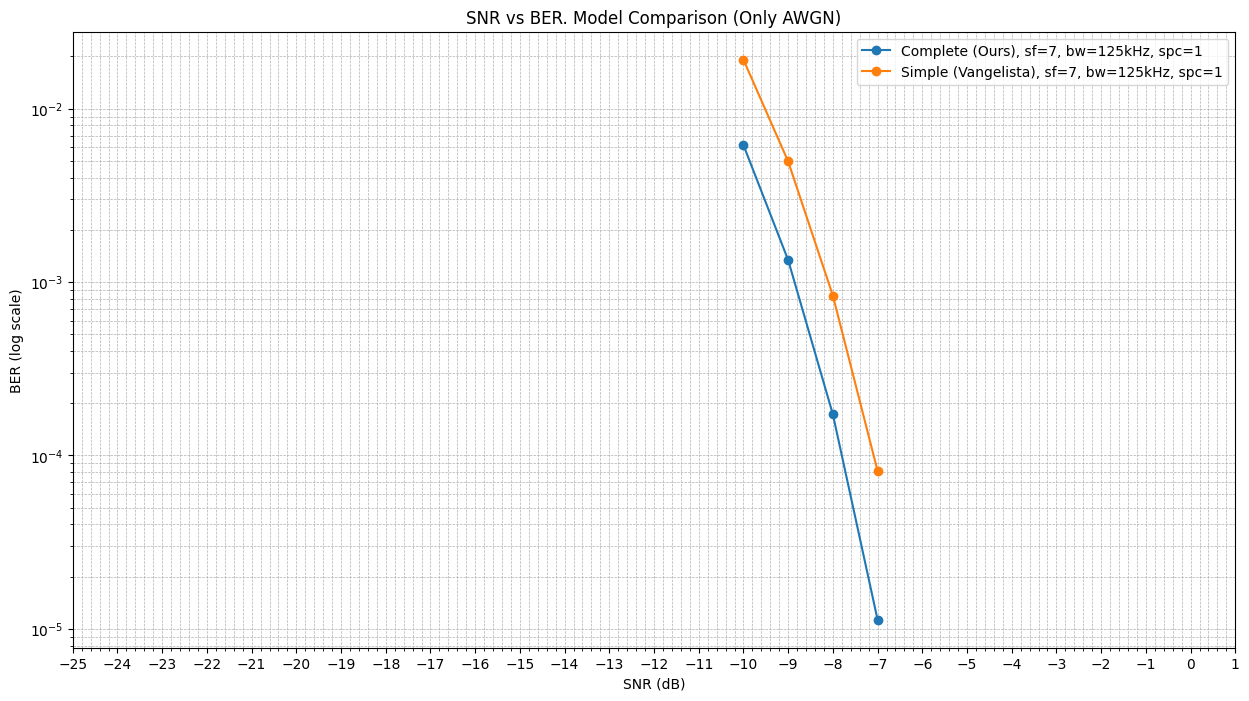

In [38]:
plt.figure(figsize=(15, 8))
plt.title(f'SNR vs BER. Model Comparison (Only AWGN)')
plot_BER_SNR_from_binary('Measures/OnlyAWGN/BER_SNR_sf7_bw125k_spc1_mod_complete.npy', 7, 1, label_fill = "Complete (Ours), sf=7, bw=125kHz, spc=1")
plot_BER_SNR_from_binary('Measures/OnlyAWGN/BER_SNR_sf7_bw125k_spc1_mod_simple.npy', 7, 1, label_fill = "Simple (Vangelista), sf=7, bw=125kHz, spc=1")
plt.legend()
plt.show()

### Métrica de Rendimiento cuantitativa **SNRxSER**, Solo AWGN

In [39]:
def generate_SER_SNR_ratio_binary(sf, bw=125e3, spc=1, simulations_number=1000000, snr_range=None, modulator="complete"):
    """Genera la Tasa de Error de Símbolo (SER) vs Relación Señal a Ruido (SNR) para un Spreading Factor (sf) dado y la guarda en un archivo binario."""
    import numpy as np
    
    # Inicializa el rango de SNR, genera todos los símbolos posibles, inicializa el demodulador y listas de resultados
    if snr_range is None:
        snr_range = np.arange(-30 + 12 - sf, 2, 1)
    
    if modulator == "simple":
        demod = SimpleLoraMoDem(sf, bw, spc)
    elif modulator == "complete":
        demod = LoraDemodulator(sf, bw, spc)
    else:
        raise ValueError("El parámetro 'modulator' debe ser 'simple' o 'complete'.")
    
    symbol_signals = generate_all_symbols(sf, spc, bw, modulator)
    SNR_values = []
    SER_values = []
    
    for snr in snr_range:
        print(f'Procesando SER para SNR = {snr} dB')
        symbol_errors = 0

        for _ in range(simulations_number):
            # Selecciona un símbolo aleatorio y su señal modulada
            message = np.random.randint(0, 2**sf)
            signal = symbol_signals[message]
            
            # Agrega ruido AWGN a la señal
            noisy_signal, _, _ = generate_awgn(f'{snr}dB', signal)
            
            # Demodula el símbolo recibido
            demodulated_message = demod.demodulate_symbols(noisy_signal)[0]

            # Compara el símbolo demodulado con el símbolo transmitido
            if demodulated_message != message:
                symbol_errors += 1
                    
        # Calcula la Tasa de Error de Símbolo (SER)
        SER = symbol_errors / simulations_number
        SNR_values.append(snr)
        SER_values.append(SER)
        print(f'SER para SNR = {snr} dB es {SER}')
    
    # Convierte las listas a arrays de numpy
    SNR_values = np.array(SNR_values)
    SER_values = np.array(SER_values)

    # Guarda los resultados en un archivo binario
    np.save(f'Measures/OnlyAWGN/SER_SNR_sf{sf}_bw{int(bw/1e3)}k_spc{spc}_mod_{modulator}_example.npy', np.vstack((SNR_values, SER_values)))

    print(f"Métricas SER-SNR generadas exitosamente para un Spreading Factor de {sf}, {spc} muestras por chip y {simulations_number} simulaciones.")


Una vez realizado el generador se procede a generar las métricas de rendimiento para distintas configuraciones LoRa.

In [40]:
# Se generarán aquí las métricas para comparar modelos:
# - Spreading Factor 7, Bandwidth 125kHz, Samples per chip 1 utilizando MoDem completo (es decir, el nuestro) y el simple (el de Vangelista)
# - Además, se extiende el rango de SNR a [-15, -4] dB
snr_range = np.arange(-15, -5)
simulations_number = 1000000
#generate_SER_SNR_ratio_binary(sf=7, bw=125e3, spc=1, simulations_number=simulations_number, snr_range=snr_range, modulator = "complete")
#generate_SER_SNR_ratio_binary(sf=7, bw=125e3, spc=1, simulations_number=simulations_number, snr_range=snr_range, modulator = "simple")

Se puede visualizar entonces, las métricas de rendimiento:

In [41]:
def plot_SER_SNR_from_binary(filename, sf ,spc, label_fill):
    # Load the binary file
    data = np.load(filename)
    SNR_values = data[0, :]
    BER_values = data[1, :]
    # Plot the data
    plt.plot(SNR_values, BER_values, marker='o', linestyle='-', label=label_fill)
    plt.xlim([SNR_values.min(), SNR_values.max()])
    plt.yscale('log')  # Logarithmic scale for BER
    plt.xticks(np.arange(-30 + 12 - sf, 2, 1))
    plt.xlabel('SNR (dB)')
    plt.ylabel('SER')
    plt.grid(True)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()

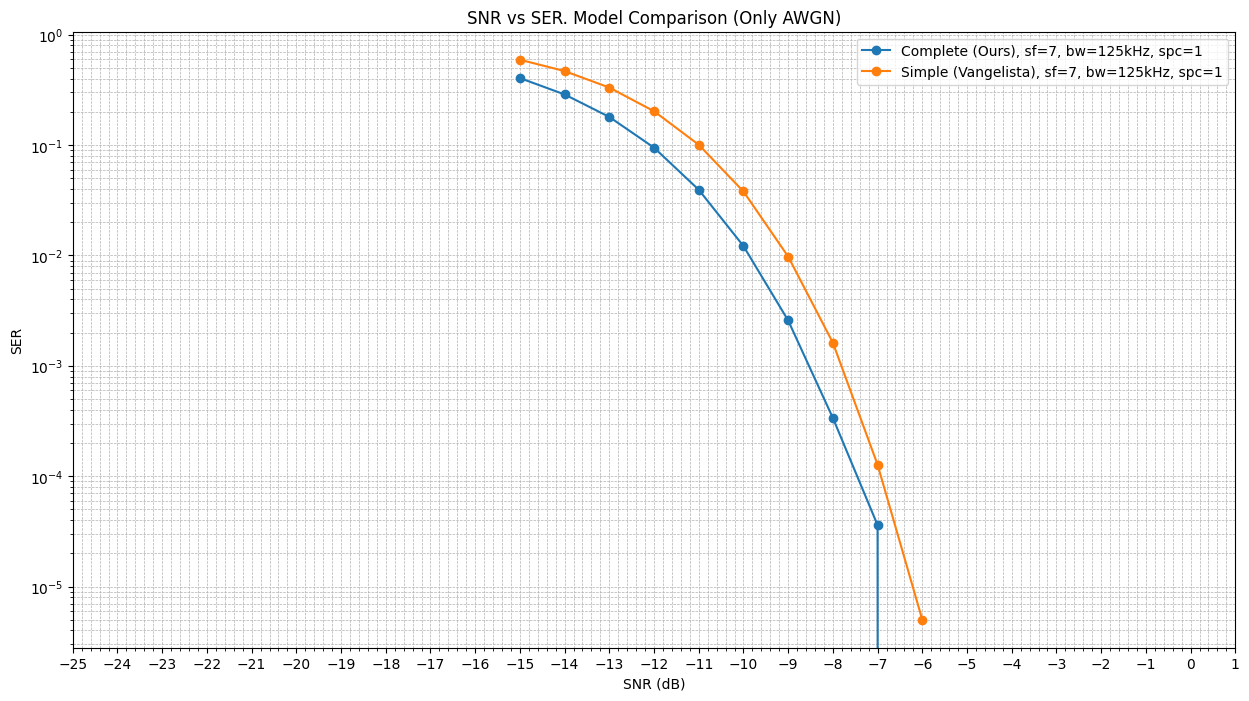

In [42]:
plt.figure(figsize=(15, 8))
plt.title(f'SNR vs SER. Model Comparison (Only AWGN)')
plot_SER_SNR_from_binary('Measures/OnlyAWGN/SER_SNR_sf7_bw125k_spc1_mod_complete.npy', 7, 1, label_fill = "Complete (Ours), sf=7, bw=125kHz, spc=1")
plot_SER_SNR_from_binary('Measures/OnlyAWGN/SER_SNR_sf7_bw125k_spc1_mod_simple.npy', 7, 1, label_fill = "Simple (Vangelista), sf=7, bw=125kHz, spc=1")
plt.legend()
plt.show()

### Métrica de Rendimiento cuantitativa **SNRxBER**, canal con Frecuencia Selectiva

In [43]:
def generate_BER_SNR_ratio_binary_selective(sf, bw=125e3, spc=1, simulations_number=1000000, snr_range=None, modulator = "complete"):
    """Generates the Bit Error Rate (BER) vs Signal-to-Noise Ratio (SNR) for a given Spreading Factor (sf) and saves it in a binary file."""
    # Inicializa rango de SNR, todo simbolo posible para enviar, demodulador LoRa y listas de resultados
    if snr_range is None:
        snr_range = np.arange(-30 + 12 - sf, 2, 1)
    bits_per_symbol = sf
    if modulator == "simple":
        demod = SimpleLoraMoDem(sf, bw, spc)
    elif modulator == "complete":
        demod = LoraDemodulator(sf, bw, spc)
    symbol_signals = generate_all_symbols(sf, spc, bw, modulator)
    SNR_values = []
    BER_values = []
    
    for snr in snr_range:
        print(f'Processing BER for SNR = {snr} dB')
        bit_errors = 0

        for _ in range(simulations_number):
            
            # Selecciona un símbolo aleatorio, se extra su señal ya modulada, se le añade ruido y se demodula
            message = np.random.randint(0, 2**sf)
            
            signal = symbol_signals[message]
            interference = np.concatenate((np.array([0]), np.array(signal[:-1])))
            signal = np.sqrt(0.8)*signal + np.sqrt(0.2) * interference
            # Agrega ruido AWGN a la señal
            noisy_signal = generate_awgn(f'{snr}dB', signal)[0]
            
            demodulated_message = demod.demodulate_symbols(noisy_signal)[0]

            # Se calcula la cantidad de bits erróneos mediante XOR
            bit_errors += bin(demodulated_message ^ message).count('1')
                
        # Se calcula la tasa de errores de bits (BER) y se añade a las listas
        BER = bit_errors / (simulations_number*bits_per_symbol)
        SNR_values.append(snr)
        BER_values.append(BER)
        print(f'BER for SNR = {snr} dB is {BER}')
    
    # Convierte las listas a arrays de numpy
    SNR_values = np.array(SNR_values)
    BER_values = np.array(BER_values)

    # Guarda los resultados en un archivo binario
    np.save(f'Measures/FrequencySelective/BER_SNR_sf{sf}_bw{int(bw/1e3)}k_spc{spc}_mod_{modulator}_example.npy', np.vstack((SNR_values, BER_values)))

    print(f"BER-SNR Metrics successfully generated for a Spreading Factor of {sf}, samples per chip of {spc} and {simulations_number} simulations.")

Una vez realizado el generador se procede a generar las métricas de rendimiento para distintas configuraciones LoRa.

In [44]:
# Se generarán aquí las métricas para comparar modelos:
# - Spreading Factor 7, Bandwidth 125kHz, Samples per chip 1 utilizando MoDem completo (es decir, el nuestro) y el simple (el de Vangelista)

snr_range = np.arange(-9, -3)
simulations_number = 1000000
#generate_BER_SNR_ratio_binary_selective(sf=7, bw=125e3, spc=1, simulations_number=simulations_number, snr_range=snr_range, modulator = "complete")
#generate_BER_SNR_ratio_binary_selective(sf=7, bw=125e3, spc=1, simulations_number=simulations_number, snr_range=snr_range, modulator = "simple")

Se puede visualizar entonces, las métricas de rendimiento:


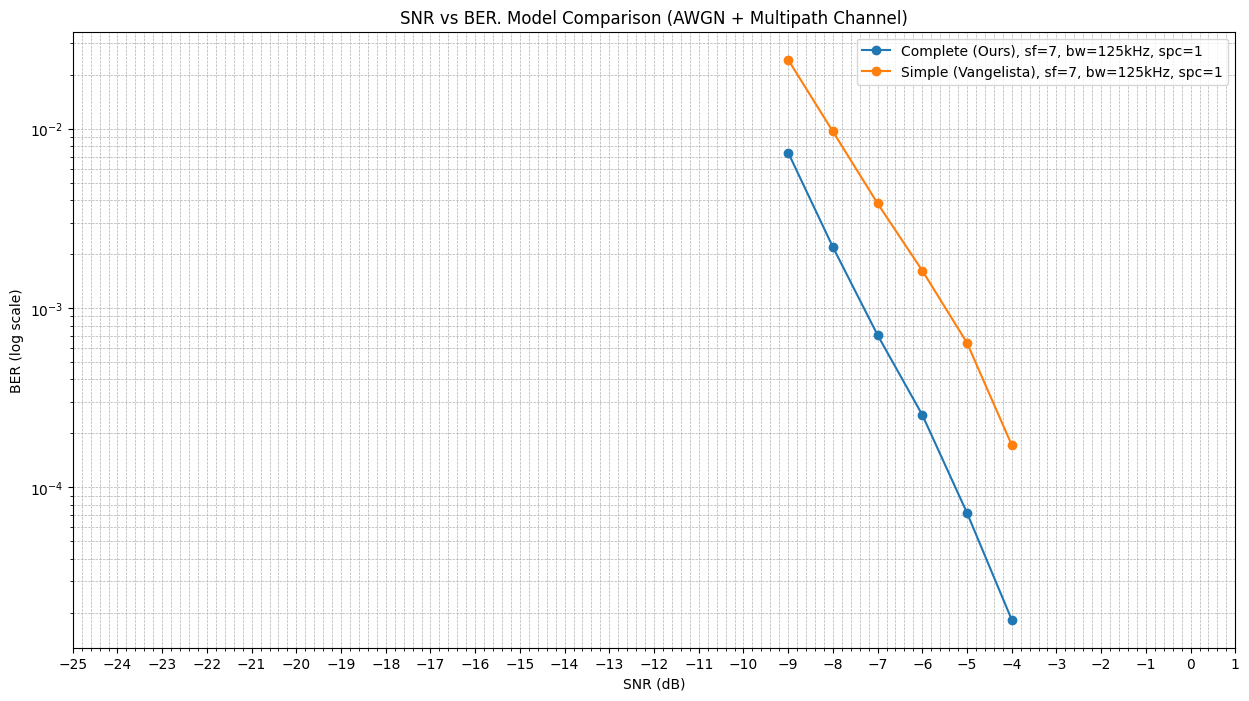

In [45]:
plt.figure(figsize=(15, 8))
plt.title(f'SNR vs BER. Model Comparison (AWGN + Multipath Channel)')
plot_BER_SNR_from_binary('Measures/FrequencySelective/BER_SNR_sf7_bw125k_spc1_mod_complete.npy', 7, 1, label_fill = "Complete (Ours), sf=7, bw=125kHz, spc=1")
plot_BER_SNR_from_binary('Measures/FrequencySelective/BER_SNR_sf7_bw125k_spc1_mod_simple.npy', 7, 1, label_fill = "Simple (Vangelista), sf=7, bw=125kHz, spc=1")
plt.legend()
plt.show()

### Métrica de Rendimiento cuantitativa **SNRxSER**,  canal con Frecuencia Selectiva

In [46]:
def generate_SER_SNR_ratio_binary_selective(sf, bw=125e3, spc=1, simulations_number=1000000, snr_range=None, modulator="complete"):
    """Genera la Tasa de Error de Símbolo (SER) vs Relación Señal a Ruido (SNR) para un Spreading Factor (sf) dado y la guarda en un archivo binario. Supone un canal de frecuencia selectiva."""
    import numpy as np
    
    # Inicializa el rango de SNR, genera todos los símbolos posibles, inicializa el demodulador y listas de resultados
    if snr_range is None:
        snr_range = np.arange(-30 + 12 - sf, 2, 1)
    
    if modulator == "simple":
        demod = SimpleLoraMoDem(sf, bw, spc)
    elif modulator == "complete":
        demod = LoraDemodulator(sf, bw, spc)
    else:
        raise ValueError("El parámetro 'modulator' debe ser 'simple' o 'complete'.")
    
    symbol_signals = generate_all_symbols(sf, spc, bw, modulator)
    SNR_values = []
    SER_values = []
    
    for snr in snr_range:
        print(f'Procesando SER para SNR = {snr} dB')
        symbol_errors = 0

        for _ in range(simulations_number):
            # Selecciona un símbolo aleatorio y su señal modulada
            message = np.random.randint(0, 2**sf)
            signal = symbol_signals[message]
            interference = np.concatenate((np.array([0]), np.array(signal[:-1])))
            signal = np.sqrt(0.8)*signal + np.sqrt(0.2) * interference
            # Agrega ruido AWGN a la señal
            noisy_signal, _, _ = generate_awgn(f'{snr}dB', signal)
            

            # Demodula el símbolo recibido
            demodulated_message = demod.demodulate_symbols(noisy_signal)[0]

            # Compara el símbolo demodulado con el símbolo transmitido
            if demodulated_message != message:
                symbol_errors += 1
                    
        # Calcula la Tasa de Error de Símbolo (SER)
        SER = symbol_errors / simulations_number
        SNR_values.append(snr)
        SER_values.append(SER)
        print(f'SER para SNR = {snr} dB es {SER}')
    
    # Convierte las listas a arrays de numpy
    SNR_values = np.array(SNR_values)
    SER_values = np.array(SER_values)

    # Guarda los resultados en un archivo binario
    np.save(f'Measures/FrequencySelective/SER_SNR_sf{sf}_bw{int(bw/1e3)}k_spc{spc}_mod_{modulator}_example.npy', np.vstack((SNR_values, SER_values)))

    print(f"Métricas SER-SNR generadas exitosamente para un Spreading Factor de {sf}, {spc} muestras por chip y {simulations_number} simulaciones.")


Una vez realizado el generador se procede a generar las métricas de rendimiento para distintas configuraciones LoRa.

In [47]:
# Se generarán aquí las métricas para comparar modelos:
# - Spreading Factor 7, Bandwidth 125kHz, Samples per chip 1 utilizando MoDem completo (es decir, el nuestro) y el simple (el de Vangelista)
# - Además, se extiende el rango de SNR a [-15, -4] dB
snr_range = np.arange(-9, -3)
simulations_number = 1000000
#generate_SER_SNR_ratio_binary_selective(sf=7, bw=125e3, spc=1, simulations_number=simulations_number, snr_range=snr_range, modulator = "complete")
#generate_SER_SNR_ratio_binary_selective(sf=7, bw=125e3, spc=1, simulations_number=simulations_number, snr_range=snr_range, modulator = "simple")

Se puede visualizar entonces, las métricas de rendimiento:

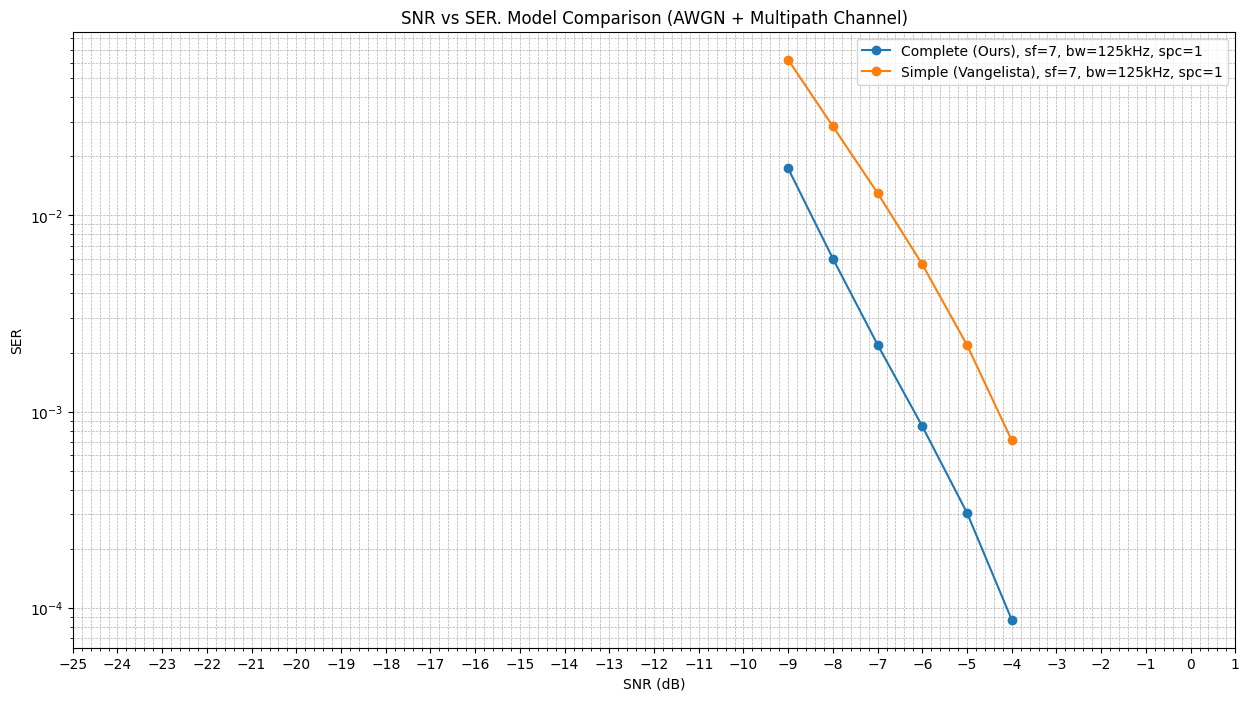

In [48]:
plt.figure(figsize=(15, 8))
plt.title(f'SNR vs SER. Model Comparison (AWGN + Multipath Channel)')
plot_SER_SNR_from_binary('Measures/FrequencySelective/SER_SNR_sf7_bw125k_spc1_mod_complete.npy', 7, 1, label_fill = "Complete (Ours), sf=7, bw=125kHz, spc=1")
plot_SER_SNR_from_binary('Measures/FrequencySelective/SER_SNR_sf7_bw125k_spc1_mod_simple.npy', 7, 1, label_fill = "Simple (Vangelista), sf=7, bw=125kHz, spc=1")
plt.legend()
plt.show()

### Métrica de Rendimiento cuantitativa **SNRxBER** + Preambulo, solo AWGN

In [49]:
from lora_modem import LoraOriginalSynchronizer, LoraCorrelationSynchronizer
def generate_framed_BER_SNR_ratio_binary(sf, bw=125e3, spc=1, simulations_number=1000000, snr=1):
    """Generates the Bit Error Rate (BER) vs Signal-to-Noise Ratio (SNR) for a given Spreading Factor (sf) and saves it in a binary file."""
    # Inicializa rango de SNR, todo simbolo posible para enviar, demodulador LoRa y listas de resultados

    bits_per_symbol = sf
    demod = LoraDemodulator(sf, bw, spc)

    og_sync = LoraOriginalSynchronizer(sf, spc, demod, preamble_number=8, verbose=False)
    mod = LoraModulator(sf, bw, spc)
    sync_basis = mod.get_sync_basis()
    corr_sync = LoraCorrelationSynchronizer(sf, spc, bw, sync_basis, verbose=False)
    
    symbol_signals = generate_all_framed_symbols(sf, spc, bw)
    SNR_values = []
    BER_CORR_values = []
    BER_OG_values = []

    
    print(f'Processing BER for SNR = {snr} dB')
    og_bit_errors = 0
    corr_bit_errors = 0
    for _ in range(simulations_number):
        
        # Selecciona un símbolo aleatorio, se extra su señal ya modulada, se le añade ruido y se demodula
        message = np.random.randint(0, 2**sf)
        
        signal = symbol_signals[message]

        #Se le agrega una ceros al principio aleatorios para simular desincronización
        num_zeros = np.random.randint(1, 100)
        signal = np.concatenate((np.zeros(num_zeros), signal))
        

        noisy_signal = generate_awgn(f'{snr}dB', signal)[0]

        try:
            og_synced_signal = og_sync.synchronize_rx_buffer(noisy_signal)
        except:
            og_synced_signal = None

        if og_synced_signal is None or len(og_synced_signal) == 0:
            og_bit_errors += bits_per_symbol
        else:
            og_demodulated_message = demod.demodulate_symbols(og_synced_signal)[0]
            og_bit_errors += bin(og_demodulated_message ^ message).count('1')
        
        try:
            corr_synced_signal = corr_sync.synchronize_rx_buffer(noisy_signal)
        except:
            corr_synced_signal = None
        
        if corr_synced_signal is None:
            corr_bit_errors += bits_per_symbol
        else:
            corr_demodulated_message = demod.demodulate_symbols(corr_synced_signal)[0]
            corr_bit_errors += bin(corr_demodulated_message ^ message).count('1')
            
           
    # Se calcula la tasa de errores de bits (BER) y se añade a las listas
    og_BER = og_bit_errors / (simulations_number*bits_per_symbol)
    corr_BER = corr_bit_errors / (simulations_number*bits_per_symbol)
    SNR_values.append(snr)
    BER_OG_values.append(og_BER)
    BER_CORR_values.append(corr_BER)
    print(f'BER for SNR = {snr} dB is {og_BER} with Original Synchronizer')
    print(f'BER for SNR = {snr} dB is {corr_BER} with Correlation Synchronizer')
    
    # Convierte las listas a arrays de numpy
    SNR_values = np.array(SNR_values)
    BER_OG_values = np.array(BER_OG_values)
    BER_CORR_values = np.array(BER_CORR_values)

    # Guarda los resultados en un archivo binario
    np.save(f'Measures/FramePerf/BER_SNR{snr}_sf{sf}_bw{int(bw/1e3)}k_spc{spc}_og_sync.npy', np.vstack((SNR_values, BER_OG_values)))
    np.save(f'Measures/FramePerf/BER_SNR{snr}_sf{sf}_bw{int(bw/1e3)}k_spc{spc}_corr_sync.npy', np.vstack((SNR_values, BER_CORR_values)))
    

    print(f"BER-SNR Metrics successfully generated for a Spreading Factor of {sf}, samples per chip of {spc} and {simulations_number} simulations.")

In [50]:
#generate_framed_BER_SNR_ratio_binary(sf=7, bw=125e3, spc=1, simulations_number=1000000, snr=1)

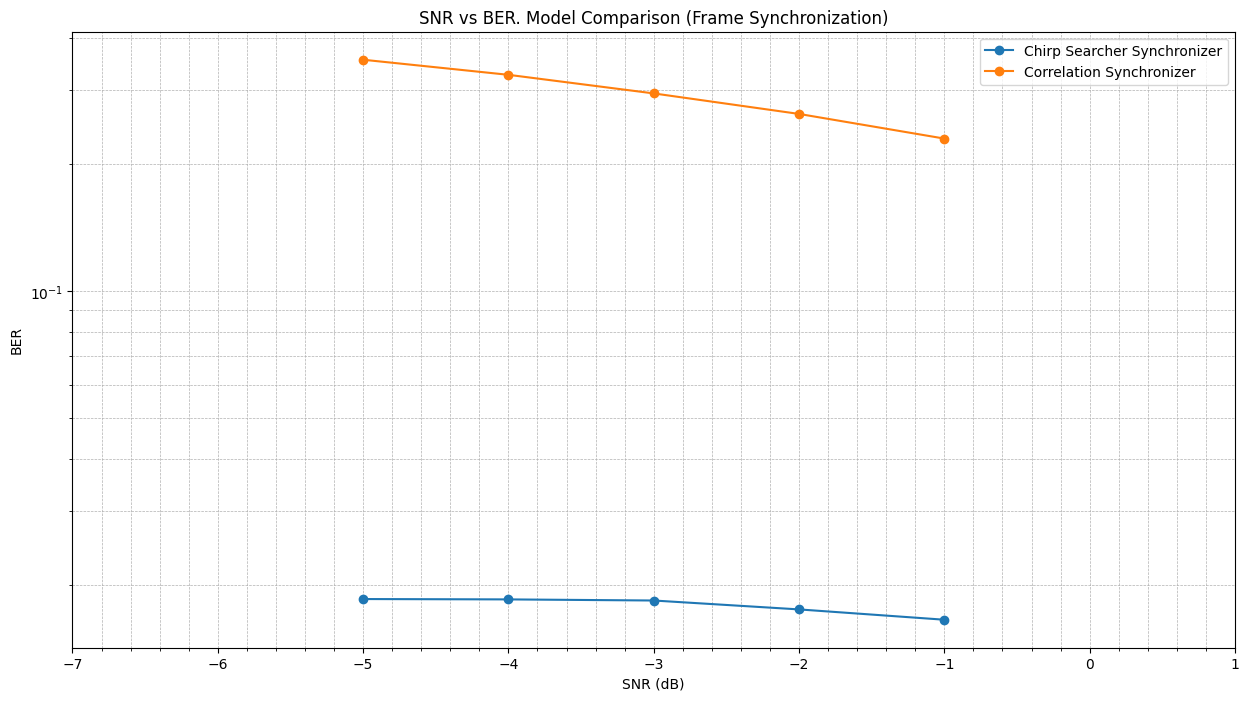

In [51]:
from matplotlib import pyplot as plt
def plot_BER_SNR_from_binary(filename, sf ,spc, label_fill):
    # Load the binary file
    data = np.load(filename)
    SNR_values = data[0, :]
    BER_values = data[1, :]
    # Plot the data
    plt.plot(SNR_values, BER_values, marker='o', linestyle='-', label=label_fill)
    plt.xlim([SNR_values.min(), SNR_values.max()])
    plt.yscale('log')  # Logarithmic scale for BER
    plt.xticks(np.arange(-7, 2, 1))
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    
    plt.grid(True)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()

plt.figure(figsize=(15, 8))
plt.title(f'SNR vs BER. Model Comparison (Frame Synchronization)')
plot_BER_SNR_from_binary('Measures/FramePerf/BER_og.npy', 7, 1, label_fill = "Chirp Searcher Synchronizer")
plot_BER_SNR_from_binary('Measures/FramePerf/BER_corr.npy', 7, 1, label_fill = "Correlation Synchronizer")
plt.legend()
plt.show()

## Complemento: Espectograma

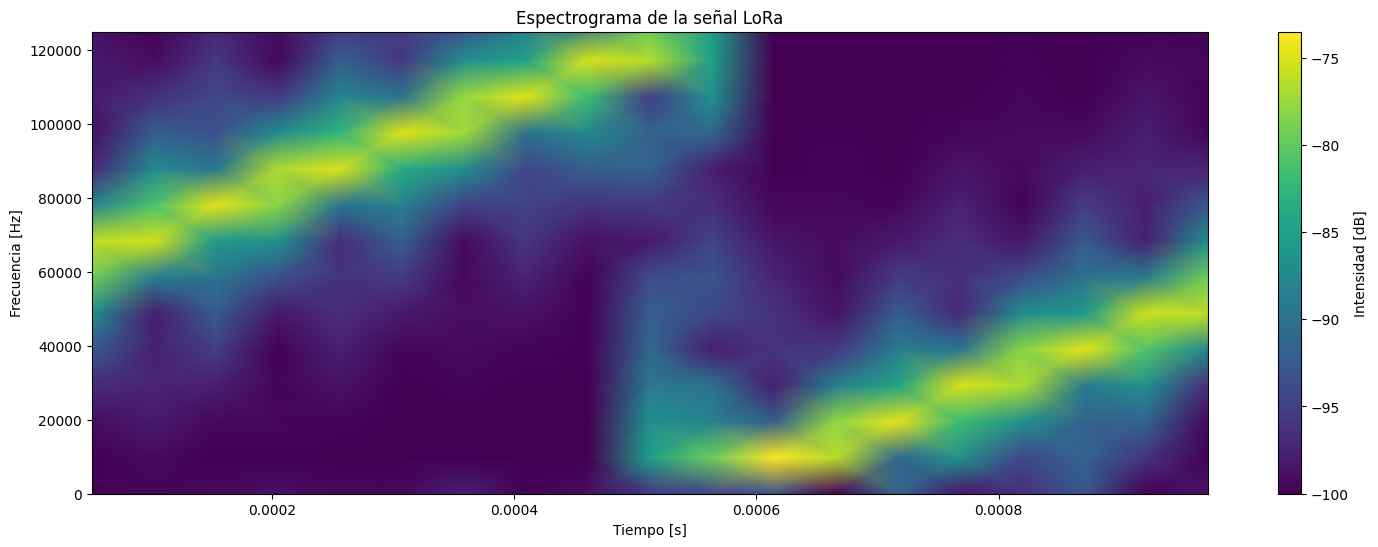

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

spreading_factor, bandwidth, samples_per_chip = 7, 125e3, 10
lora_modulator = LoraModulator(spreading_factor, bandwidth, samples_per_chip)
t, _, signal = lora_modulator.modulate_symbols([60])

#Frecuencia de Muestreo
sampling_frequency = bandwidth * samples_per_chip

# Generar el espectrograma
frequencies, times, Sxx = spectrogram(np.real(signal), fs=sampling_frequency, nperseg=int(len(signal)/10), noverlap=int(len(signal)/20))

# Graficar el espectrograma
plt.figure(figsize=(18, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
plt.colorbar(label='Intensidad [dB]')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title('Espectrograma de la señal LoRa')
plt.ylim([0, 125e3])
plt.show()